# Pengembangan Machine Learning (DICODING)
<a href = 'https://www.linkedin.com/in/louis-widi-anandaputra-90008815a/' target = '_blank'> Louis Widi Anandaputra</a>
## Proyek Akhir : Image Classification Model Deployment
- Dataset yang akan dipakai bebas, namun minimal memiliki 1000 buah gambar.
- Dataset tidak pernah digunakan pada submission kelas machine learning sebelumnya.
- Dataset dibagi menjadi 80% train set dan 20% test set.
- Model harus menggunakan model sequential.
- Model harus menggunakan Conv2D Maxpooling Layer.
- Akurasi pada training dan validation set minimal sebesar 80%.
- Menggunakan Callback.
- Membuat plot terhadap akurasi dan loss model.
- Menulis kode untuk menyimpan model ke dalam format TF-Lite.

## 1. Persiapan Library

In [237]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report

from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

from PIL import Image
import visualkeras

## 2. Persiapan Dataset

In [150]:
cifar10_classes = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

In [145]:
# Pemisahan standard train dan test yang dimiliki oleh CIFAR10
(x_train,y_train), (x_test,y_test) = datasets.cifar10.load_data()

CIFAR 10<a href = 'https://www.cs.toronto.edu/~kriz/cifar.html' target = '_blank'>[1]</a> merupakan dataset yang dikembangkan oleh Alex Krizhevsky. Dataset ini memiliki total 60.000 gambar dengan 10 kelas berbeda seperti yang ada pada dictionary sebelumnya. Dataset ini merupakan data gambar yang diperoleh dari ribuan gambar berbeda dengan resolusi yang berbeda, yang diubah menjadi gambar dengan resolusi rendah sebesar 32x32 pixel dengan 3 channel warna. Gambar dengan resolusi rendah ini akan menjadi tantangan tersendiri bagi model untuk mengekstraksi fitur-fitur pada gambar, sehingga dataset ini seringkali digunakan sebagai benchmark untuk performa suatu arsitektur yang dikembangkan. Salah satu arsitektur yang dikembangkan oleh pihak ketiga akan digunakan pada projek kali ini dan memiliki nama Simpnet <a href = 'https://paperswithcode.com/paper/towards-principled-design-of-deep' target = '_blank'>[2]</a>.

In [146]:
# Split data menjadi training dan validation
test_size = 0.2  # 20% validation, 80% training
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=test_size, random_state=42)

In [147]:
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [148]:
print("Training set shapes:", x_train.shape, y_train.shape)
print("Validation set shapes:", x_val.shape, y_val.shape)
print("Testing set shapes:", x_test.shape, y_test.shape)

Training set shapes: (40000, 32, 32, 3) (40000, 10)
Validation set shapes: (10000, 32, 32, 3) (10000, 10)
Testing set shapes: (10000, 32, 32, 3) (10000, 10)


(-0.5, 31.5, 31.5, -0.5)

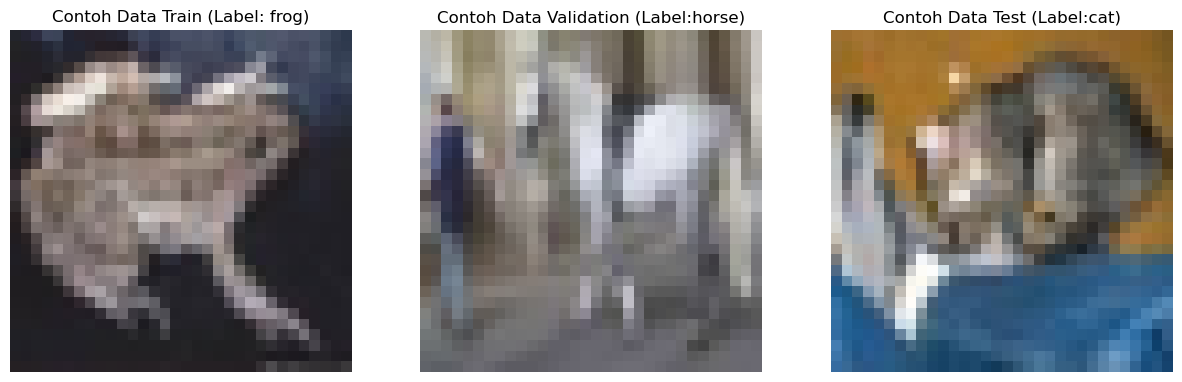

In [155]:
# Menunjukkan contoh data pada training, validasi, dan tes
fig, ax = plt.subplots(ncols = 3, figsize = (15,15))

ax[0].imshow(x_train[0])
ax[0].set_title(f"Contoh Data Train (Label: {cifar10_classes[np.argmax(y_train[0])]})")
ax[0].axis("off")

ax[1].imshow(x_val[0])
ax[1].set_title(f"Contoh Data Validation (Label:{cifar10_classes[np.argmax(y_val[0])]})")
ax[1].axis("off")

ax[2].imshow(x_test[0])
ax[2].set_title(f"Contoh Data Test (Label:{cifar10_classes[np.argmax(y_test[0])]})")
ax[2].axis("off")

In [157]:
# Augmentasi untuk data Training
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

## 3. Modelling

Model yang akan mengambil basis dari arsitektur <a href = 'https://paperswithcode.com/paper/towards-principled-design-of-deep' target = '_blank'>Simpnet</a> yang ditrain ulang. Seperti yang ada pada gambar di bawah, ide umum dari simpnet adalah penggunaan maxpooling pada setiap 5 convolutional layer, serta akan menggunakan global average pooling di akhir convolutional layer sebelum mengimplementasikan dense layer guna mendapatkan hasil klasifikasi akhir melalui aktivasi softmax.

<img src = 'simpnet.jpeg'>

In [89]:
# Sequential model
model = keras.Sequential()

model.add(layers.Conv2D(66, kernel_size=3, padding='same', input_shape=(32, 32, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, kernel_size=3, padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, kernel_size=3, padding='same', kernel_initializer='RandomNormal'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, kernel_size=3, padding='same', kernel_initializer='RandomNormal'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(192, kernel_size=3, padding='same', kernel_initializer='RandomNormal'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=2, strides=2))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(192, kernel_size=3, padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(192, kernel_size=3, padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(192, kernel_size=3, padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(192, kernel_size=3, padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(288, kernel_size=3, padding='same', kernel_initializer='RandomNormal'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=2, strides=2))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(288, kernel_size=3, padding='same', kernel_initializer='RandomNormal'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(355, kernel_size=3))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(432, kernel_size=3))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.3))

# Global Average Pooling layer
model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

model.add(layers.Dense(10, activation='softmax'))

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary model
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_108 (Conv2D)         (None, 32, 32, 66)        1848      
                                                                 
 batch_normalization_116 (Ba  (None, 32, 32, 66)       264       
 tchNormalization)                                               
                                                                 
 activation_108 (Activation)  (None, 32, 32, 66)       0         
                                                                 
 dropout_116 (Dropout)       (None, 32, 32, 66)        0         
                                                                 
 conv2d_109 (Conv2D)         (None, 32, 32, 128)       76160     
                                                                 
 batch_normalization_117 (Ba  (None, 32, 32, 128)      512       
 tchNormalization)                                   

Seperti yang ditunjukkan oleh cell di atas, Simpnet memiliki lebih dari 5 juta parameter yang dapat ditrain. Hal ini akan mempengaruhi durasi proses fitting, dimana model akan mencoba melakukan back-propagation untuk mencari weights terbaik.

In [236]:
# # Kode untuk melihat arsitektur model
# visualkeras.layered_view(model)

In [158]:
# EarlyStopping callback
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',  
                               patience=15, 
                               restore_best_weights=True,  
                               verbose=1)  # Print informasi tentang early stopping pada console

In [159]:
# Fitting model
history = model.fit(train_datagen.flow(x_train, y_train, batch_size=32), # Menggunakan datagen untuk augmentasi
                    epochs=100,  
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping])

Epoch 1/100
1250/1250 [==============================] - 1213s 970ms/step - loss: 0.9129 - accuracy: 0.6991 - val_loss: 0.5583 - val_accuracy: 0.8130
Epoch 2/100
1250/1250 [==============================] - 1230s 984ms/step - loss: 0.7708 - accuracy: 0.7348 - val_loss: 0.4530 - val_accuracy: 0.8477
Epoch 3/100
1250/1250 [==============================] - 1381s 1s/step - loss: 0.7233 - accuracy: 0.7556 - val_loss: 0.5640 - val_accuracy: 0.8225
Epoch 4/100
1250/1250 [==============================] - 1401s 1s/step - loss: 0.6866 - accuracy: 0.7672 - val_loss: 0.4559 - val_accuracy: 0.8502
Epoch 5/100
1250/1250 [==============================] - 1322s 1s/step - loss: 0.6645 - accuracy: 0.7722 - val_loss: 0.4609 - val_accuracy: 0.8474
Epoch 6/100
1250/1250 [==============================] - 1269s 1s/step - loss: 0.6386 - accuracy: 0.7807 - val_loss: 0.4414 - val_accuracy: 0.8551
Epoch 7/100
1250/1250 [==============================] - 1260s 1s/step - loss: 0.6158 - accuracy: 0.7896 - val_l

Model melakukan proses fitting selama lebih dari 20 menit pada setiap epoch dan model berjalan selama 100 epoch tanpa menggunakan callback. Jika ditotal, fitting CIFAR10 sebagai dataset benchmarking untuk arsitektur Simpnet membutuhkan lebih dari 33 jam. Dua alternatif yang dapat dilakukan dalam kasus seperti ini adalah pertama untuk melakukan proses training menggunakan arsitektur yang lebih kecil dengan mengimplementasi depthwise atau pointwise convolution seperti <a href='https://arxiv.org/abs/1704.04861' target = '_blank'>mobilenet</a> yang memiliki kemampuan mengekstrak fitur pada gambar yang baik tanpa harus mengimplementasikan convolution normal yang memiliki kompleksitas yang berat. Alternatif lain adalah untuk menggunakan hardware yang lebih mumpuni, dimana hal ini didasari melalui pengalaman proses training model simpnet ini menggunakan hardware yang hanya memiliki 8gb RAM. Banyak kasus menunjukkan penggunaan HPC, dimana HPC sendiri dapat diakses secara remote melalui layanan cloud seperti yang dimiliki oleh <a href = 'https://cloud.google.com/solutions/hpc' target = '_blank'>Google</a>.

## 4. Evaluasi Model

/var/folders/kp/1yj5j5nx6gddj5pqbjbnl45r0000gn/T/ipykernel_42893/4192030707.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


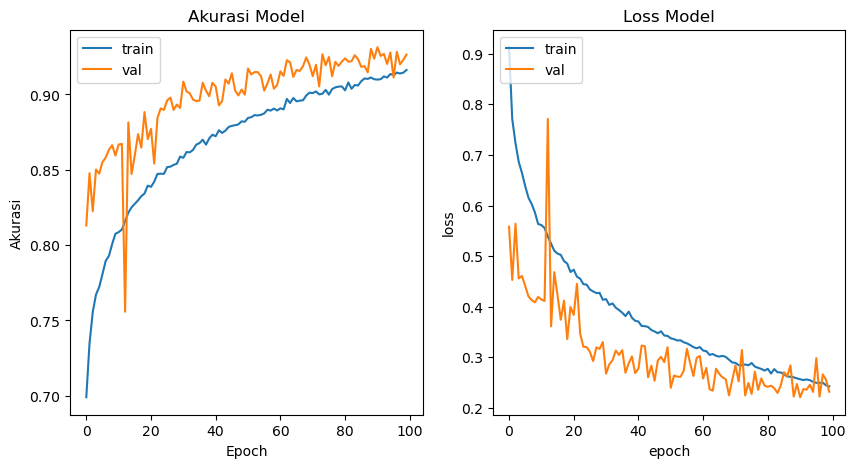

In [238]:
fig, ax = plt.subplots(ncols = 2, figsize = (10,5))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Akurasi Model')
ax[0].set_ylabel('Akurasi')
ax[0].set_xlabel('Epoch')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss Model')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')

fig.show()

Dikarenakan proses augmentasi menyebabkan 40.000 data train berjumlah lebih banyak lagi, 10.000 data validasi lebih mudah untuk diprediksi. Hal ini menjadi alasan proses training memiliki akurasi dan loss yang cenderung lebih buruk dari validasi. Akan tetapi, secara umum, model tidak overfit ataupun underfit, hal ini karena tren yang dimiliki oleh proses validation mirip seperti tren yang dimiliki oleh proses training. Ketika loss turun pada training, maka loss akan turun pula pada validation, sama seperti akurasi pada train dan validasi.

In [169]:
# Predict the classes for the test data
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

313/313 [==============================] - 75s 239ms/step


In [170]:
# Convert one-hot encoded labels to integers
y_test_classes = np.argmax(y_test, axis=1)

classification_report_result = classification_report(y_test_classes, y_pred_classes)

In [171]:
print(classification_report_result)

              precision    recall  f1-score   support

           0       0.94      0.89      0.91      1000
           1       0.93      0.98      0.95      1000
           2       0.87      0.92      0.90      1000
           3       0.87      0.86      0.87      1000
           4       0.95      0.90      0.92      1000
           5       0.94      0.84      0.89      1000
           6       0.90      0.97      0.93      1000
           7       0.93      0.96      0.95      1000
           8       0.95      0.93      0.94      1000
           9       0.93      0.96      0.94      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



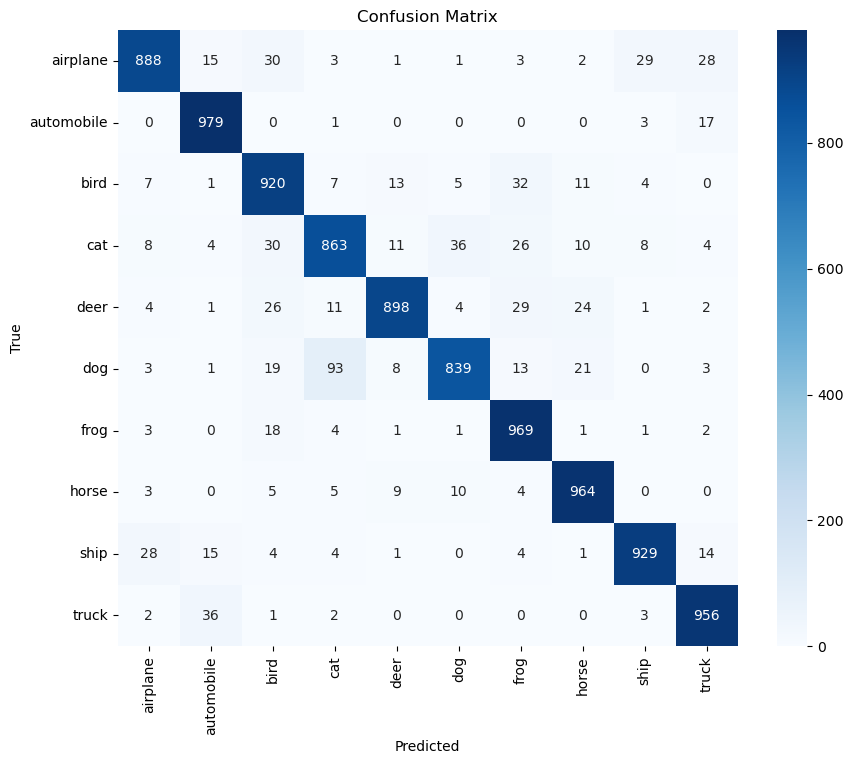

In [172]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=cifar10_classes.values(), yticklabels=cifar10_classes.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Model secara umum dapat memprediksi dengan baik. Proses training menunjukkan hasil akhir akurasi training maksimal sebesar 91.62%, meski tidak mencapai 92%, perlu diperhatikan bahwa ini merupakan dampak dari <b>augmentasi data train</b> yang memperbanyak data. Hasil validasi  akhir dan testing juga menunjukkan hasil yang sangat baik dengan akurasi di atas 92%. Mengevaluasi confusion matrix, terdapat sedikit 'confusion' pada anjing dan kucing, hal ini diduga karena fitur edges dan oriented gradient yang dimiliki oleh objek kucing dan anjing cukup mirip. 'Confusion' lain juga terdapat pada saat model mencoba memprediksi truk dan automobile. Sehingga, metode-metode 'image processing' dapat dilakukan untuk meningkatkan performa model. 

In [222]:
# Menyimpan data proses training
hist_df = pd.DataFrame(history.history) 
hist_df.to_csv("Train_History.csv", index = False) 

In [207]:
test_image = plt.imread('test_image.jpeg')

(-0.5, 31.5, 31.5, -0.5)

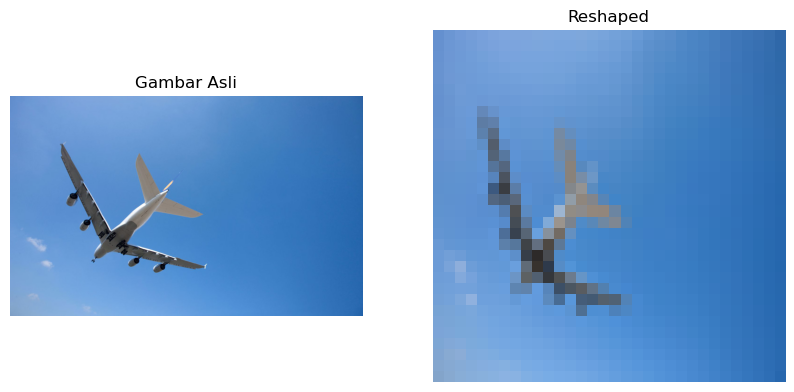

In [223]:
# Reshape Gambar
test_image_reshaped = np.array(Image.fromarray(test_image).resize((32, 32)))
test_image_reshaped = np.reshape(test_image_reshaped, (1, 32, 32, 3))
fig,ax = plt.subplots(ncols = 2, figsize = (10,10))
# Menunjukan gambar
ax[0].imshow(test_image)
ax[0].set_title("Gambar Asli")
ax[0].axis("off")

ax[1].imshow(test_image_reshaped[0])
ax[1].set_title("Reshaped")
ax[1].axis("off")

In [225]:
sample_prediction = model.predict(test_image_reshaped)
print(f"Prediksi Gambar Sampel: {cifar10_classes[np.argmax(sample_prediction)]}")

1/1 [==============================] - 0s 42ms/step
Prediksi Gambar Sampel: airplane


Model dapat memprediksi gambar eksternal dengan baik.

## 5. Deployment

In [233]:
# menyimpan model dengan format h5
model.save('model/simpnet.h5')

In [234]:
# menyimpan model dengan format tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/kp/1yj5j5nx6gddj5pqbjbnl45r0000gn/T/tmp9h_1db13/assets


INFO:tensorflow:Assets written to: /var/folders/kp/1yj5j5nx6gddj5pqbjbnl45r0000gn/T/tmp9h_1db13/assets
2023-12-26 09:00:56.325117: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-12-26 09:00:56.325138: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-12-26 09:00:56.325233: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/kp/1yj5j5nx6gddj5pqbjbnl45r0000gn/T/tmp9h_1db13
2023-12-26 09:00:56.331131: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-12-26 09:00:56.331139: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/kp/1yj5j5nx6gddj5pqbjbnl45r0000gn/T/tmp9h_1db13
2023-12-26 09:00:56.355931: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-12-26 09:00:56.589061: I tensorflow/cc/saved_model/loader.cc:213] Running initialization

In [235]:
# write file tfLite pada system
with tf.io.gfile.GFile('model/simpnet.tflite', 'wb') as f:
    f.write(tflite_model)

## Kesimpulan

Secara umum, model Simpnet yang ditrain ulang menggunakan metode tersendiri pada projek ini memiliki performa yang baik ketika dilakukan benchmark pada dataset CIFAR10. Dataset yang dibagi menjadi 40.000 training (ditambah augmentasi), 10.000 validation, dan 10.000 testing dapat digunakan oleh model dengan baik. Langkah selanjutnya untuk mengembangkan projek ini sehingga menjadi lebih baik adalah penggunaan pendekatan deep learning lain seperti Residual Networks <a href = 'https://arxiv.org/abs/1512.03385' target = '_blank'>[3] </a> dan Squeeze & Excitation Networks <a href = 'https://ieeexplore.ieee.org/document/8578843' target = '_blank'>[4]</a>. Penggunaan model pretrained sebagai feature extractor juga dapat meningkatkan performa dan efisiensi dari model ini.

### Referensi

[1] Krizhevsky, A., Nair, V. and Hinton, G. (2014) The CIFAR-10 Dataset.
https://www.cs.toronto.edu/~kriz/cifar.html

[2] S. H. Hasanpour, M. Rouhani, M. Fayyaz, M. Sabokrou, and E. Adeli, “Towards Principled Design of Deep Convolutional Networks: Introducing SimpNet.” arXiv, 2018. doi: 10.48550/ARXIV.1802.06205.

[3] K. He, X. Zhang, S. Ren, and J. Sun, “Deep Residual Learning for Image Recognition.” arXiv, 2015. doi: 10.48550/ARXIV.1512.03385.

[4] J. Hu, L. Shen and G. Sun, "Squeeze-and-Excitation Networks," 2018 IEEE/CVF Conference on Computer Vision and Pattern Recognition, Salt Lake City, UT, USA, 2018, pp. 7132-7141, doi: 10.1109/CVPR.2018.00745.

© Louis Widi Anandaputra - 2023